In [222]:
import numpy as np
import matplotlib.pyplot as plt


## Transmission de données

On souhaite transmettre **6 chiffres**, chacun codé sur **64 bits**, soit :

$$6 \times 64 = 384 \text{ bits}$$

La trame totale contient donc **384 bits**.

## Fréquence d'envoi

On veut envoyer la trame **2 fois par seconde**.

Cela signifie un envoi toutes les :

- <span style="color:#BF40BF;">0.5 seconde</span> (fréquence 2 Hz)

On a une trame de 48 bits envoyée en 0.5 seconde, donc :

$$\text{Intervalle par bit} = \frac{0.5}{48} \approx 0.0104 \text{ s/bit}$$

On arrondit à :

- <span style="color:#1F51FF;">0.01 seconde par bit</span> (approximation en bleu néon)

In [223]:
def raised_cosine(T, beta, span, dt):
    """
    Génère un filtre Raised Cosine.
    
    T : période symbole (ex : 1)
    beta : roll-off (0 à 1)
    span : durée du filtre en nombre de symboles (ex : 6)
    dt : espacement entre les échantillons (sampling interval)
    """
    t = np.arange(-span*T/2, span*T/2, dt)
    h = np.zeros_like(t)

    for i, ti in enumerate(t):
        if abs(1 - (4 * beta * ti / T)**2) < 1e-10:
            # Cas limite pour éviter la division par zéro
            h[i] = beta / (2*T) * np.sin(np.pi/(2*beta))
        elif abs(ti) < 1e-10:
            # Valeur à t = 0
            h[i] = 1
        else:
            h[i] = (np.sin(np.pi * ti / T) / (np.pi * ti / T)) * \
                   (np.cos(np.pi * beta * ti / T) / (1 - (2 * beta * ti / T)**2))

    return t, h



### Filtre en Cosinus Surélevé (Raised Cosine)

$$
h(t) = \frac{\sin\left(\pi \frac{t}{T}\right)}{\pi \frac{t}{T}} \cdot \frac{\cos\left(\pi \beta \frac{t}{T}\right)}{1 - \left(2 \beta \frac{t}{T}\right)^2}
$$

**Où :**

$$
\begin{cases}
T & \text{: période symbole} \\
\beta & \text{: roll-off factor (compris entre 0 et 1)} \\
t & \text{: temps}
\end{cases}
$$

In [224]:
#------------ CONSTANTES ------------

T = 1        # période 
beta = 0.25    # roll-off
span = 8       # dure 8 symboles
dt = T / 100   # espacement d'échantillonnage



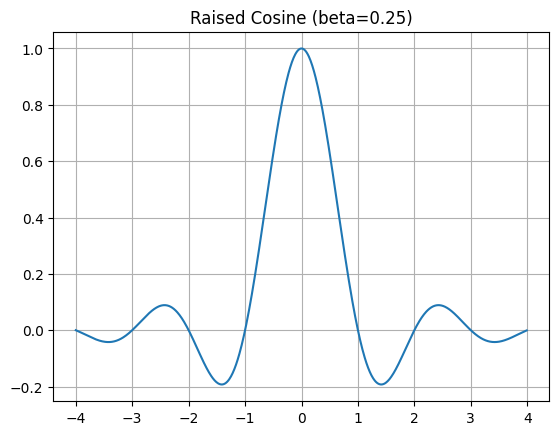

In [225]:
t, h = raised_cosine(T, beta, span, dt)

plt.plot(t, h)
plt.title("Raised Cosine (beta=0.25)")
plt.grid()
plt.show()


 We now want to generate and display the impulse response and power spectral density (PSD) of a raised-cosine filter, here is how we do it :

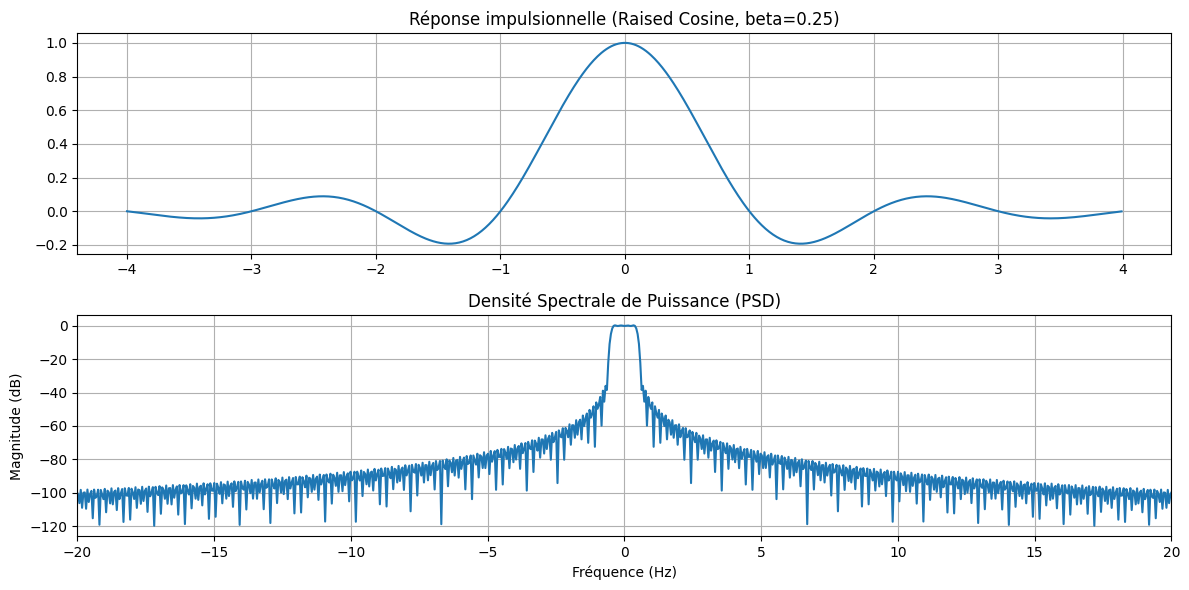

In [226]:
T = 1          # Période symbole
beta = 0.25     # Roll-off
span = 8        # Durée du filtre
fs = 100        # Fréquence d'échantillonnage (1/dt)
dt = 1/fs
fc = 10 /T        # Fréquence porteuse
sigma_a2 = 1.0   # Variance des symboles (puissance)
t, h = raised_cosine(T, beta, span, dt)

# 2. Calcul de la DSP via FFT
# On utilise un padding pour avoir une meilleure résolution fréquentielle
NFFT = 2048
H_freq = np.fft.fftshift(np.fft.fft(h, NFFT)) * dt
freqs = np.fft.fftshift(np.fft.fftfreq(NFFT, dt))

# Puissance du filtre (P_D dans ta formule)
PSD_baseband = np.abs(H_freq)**2

# 3. Application de la formule : Translation autour de +/- fc
# On simule le décalage fréquentiel
PSD_total = (sigma_a2 / T) * (np.abs(H_freq)**2)



plt.figure(figsize=(12, 6))

# Plot Temporel
plt.subplot(2, 1, 1)
plt.plot(t, h)
plt.title(f"Réponse impulsionnelle (Raised Cosine, beta={beta})")
plt.grid(True)

# PSD
plt.subplot(2, 1, 2)
plt.plot(freqs, 10 * np.log10(PSD_total + 1e-12)) # dB
plt.title("Densité Spectrale de Puissance (PSD)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(-20, 20)
plt.grid(True)

plt.tight_layout()
plt.show()


 We need a carrier frequency because the original base-band (low-frequency) pulse cannot travel efficiently through the physical channe. We use an 8 kHz carrier (instead of 8 GHz) because the lower frequency keeps the computational load tractable while still letting us visualize the modulation.

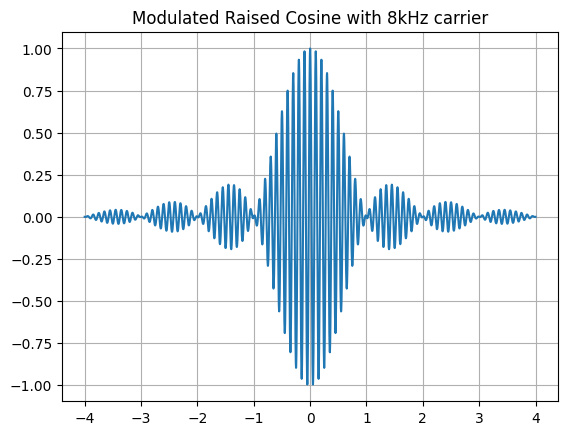

In [227]:
import scipy.signal as signal


dt_mod = T / 1000  # We start at 1000 Hz sampling for modulation
t_mod, h_mod = raised_cosine(T, beta, span, dt_mod)
fc = 10 / T  # carrier frequency in Hz, found it to be good at 10 / T after 
carrier = np.cos(2 * np.pi * fc * t_mod)
modulated = h_mod * carrier
plt.plot(t_mod, modulated)
plt.title("Modulated Raised Cosine with 8kHz carrier")
plt.grid()
plt.show()


 We now need to compute and display the power-spectral density (PSD) of a raised-cosine pulse after amplitude-modulation with de carrier frequency, using a direct FFT to verify the theoretical spectrum shape.

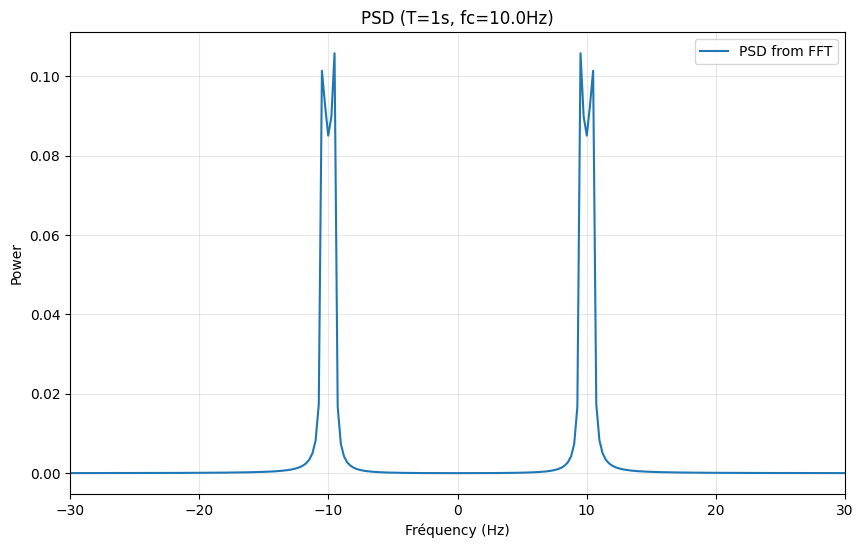

In [228]:


dt_mod = T / 1000   
fs_mod = 1 / dt_mod


t_mod, h_mod = raised_cosine(T, beta, span, dt_mod)
carrier = np.cos(2 * np.pi * fc * t_mod)
modulated = h_mod * carrier

# Psd computing
# using FFT to match the concepts saw in class
NFFT = 4096
# TF of signal 
V_f = np.fft.fftshift(np.fft.fft(modulated, NFFT)) * dt_mod
freqs = np.fft.fftshift(np.fft.fftfreq(NFFT, dt_mod))

# PSD
psd_modulated = np.abs(V_f)**2

# Plot
plt.figure(figsize=(10, 6))


plt.plot(freqs, psd_modulated, label="PSD from FFT")


plt.title(f"PSD (T={T}s, fc={fc}Hz)")
plt.xlabel("Fréquency (Hz)")
plt.ylabel("Power")
plt.grid(True, alpha=0.3)

# Zoom 
plt.xlim(-30, 30) 
plt.legend()
plt.show()


 The code below transform a J2000 state vector—six double-precision numbers representing position and velocity in AU and Km/s into a flat sequence of 384 raw bits and then expanding every byte into its individual zeros and ones, producing a binary stream ready for modulation or channel coding.

In [229]:
import struct

def j2000_to_bit_list(coords_list):
    """
    Convertit des coordonnées J2000 (AU) en une liste de bits (0 et 1).
    Chaque coordonnée est encodée sur 64 bits 

    """
    bit_list = []
    
    for vec in coords_list:
        # Conversion du vecteur (6 doubles) en 48 octets
        binary_data = struct.pack('<6d', *vec)
        
        for byte in binary_data:
            # Conversion de l'octet en bits
            bits = bin(byte)[2:].zfill(8)
            # Ajout des bits à la liste
            bit_list.extend([int(b) for b in bits])
            
    return bit_list

# --- Exemple ---

coords = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

bits = j2000_to_bit_list(coords)

print(f"Total number of bits : {len(bits)}") 
print(f"10 premiers bits : {bits[:10]}")


Total number of bits : 384
10 premiers bits : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


The function <span style="color:#3498db;">**generate_j2000_signal**</span> takes a single J2000 Cartesian state vector (six double-precision orbital elements) and turns it into a real-world RF waveform that could be sent over an **additive-white-Gaussian-noise** channel.

First it flattens the vector into <span style="color:#2ecc71;">**384 raw bits**</span> via **IEEE-754 little-endian** packing.

To avoid truncation of the filter’s tail, it appends <span style="color:#e67e22;">**span zero bits**</span>—this padding guarantees the convolution with the **raised-cosine** impulse response finishes cleanly and all useful energy is preserved.



Each bit is mapped to a narrow <span style="color:#1F51FF;">**±4 V impulse**</span> located at the **symbol epoch**.

The resulting is multiplied by the <span style="color:#BF40BF;">**carrier frequency cosine**</span> to create a pass-band signal whose spectrum is centered on the chosen carrier.

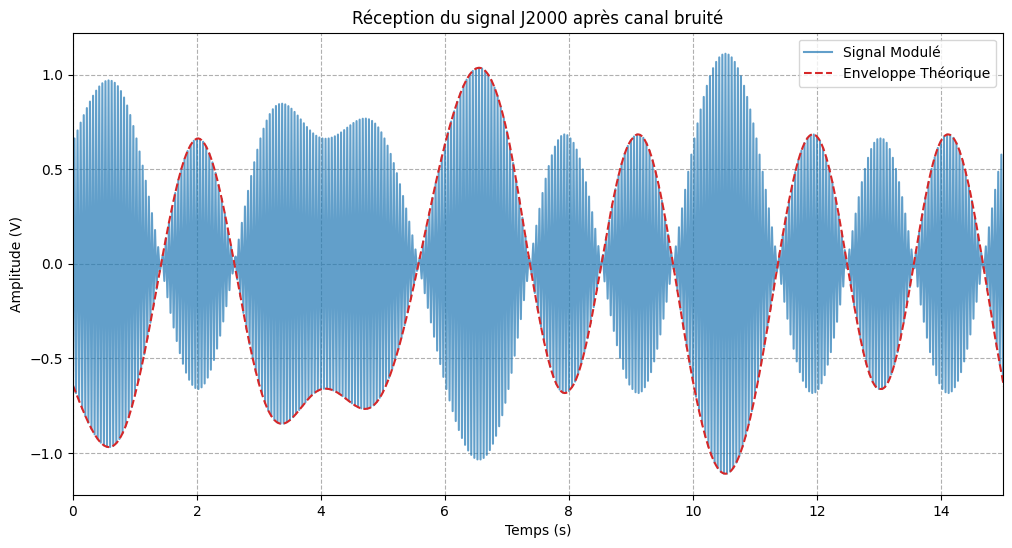

In [230]:
import numpy as np
import matplotlib.pyplot as plt
import struct

def generate_j2000_signal(coords, T=1.0, beta=0.35, span=6, fc=20):
    """
    Génère le signal modulé avec padding pour compenser le délai du filtre.
    """
    #  Conversion en bits 
    bits_utiles = j2000_to_bit_list(coords)
    

    # On ajoute des bits à 0 juste pour laisser au filtre la place de terminer sa réponse

    bits_avec_padding = bits_utiles + [0] * span
    
    num_total_bits = len(bits_avec_padding)

    # Paramètres 
    samples_per_symbol = 40  
    dt = T / samples_per_symbol
    

    # Utilisation de la liste allongée avec des 0
    impulses = np.zeros(num_total_bits * samples_per_symbol)
    for i, bit in enumerate(bits_avec_padding):
        voltage = 4 if bit == 1 else -4
        impulses[i * samples_per_symbol] = voltage

    # 5. Filtrage Raised Cosine
    t_rc, h_rc = raised_cosine(T, beta, span, dt)
    h_rc = h_rc / np.sqrt(np.sum(h_rc**2))   # <<< NORMALISATION ÉNERGIE


    baseband = np.convolve(impulses, h_rc, mode='same')

    # 6. Modulation sur fc
    t_signal = np.arange(len(baseband)) * dt
    carrier = np.cos(2 * np.pi * fc * t_signal)
    modulated_signal = baseband * carrier

    return {
        "t": t_signal,
        "modulated": modulated_signal,
        "baseband": baseband,
        "bits": bits_utiles, 
        "dt": dt
    }

# --- execution ---

test_coordinates = [[-0.1742, 0.9689, 0.0001458, -29.78, -5.21, 0.001]]


data = generate_j2000_signal(test_coordinates, T=1.0, fc=20)



#  Tracé manuel
plt.figure(figsize=(12, 6))
plt.plot(data["t"], data["modulated"], label="Signal Modulé", color='tab:blue', alpha=0.7)
plt.plot(data["t"], data["baseband"], '--', label="Enveloppe Théorique", color='tab:red')

plt.title("Réception du signal J2000 après canal bruité")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude (V)")
plt.xlim(0, 15)  # Zoom 
plt.grid(True, linestyle='--')
plt.legend()
plt.show()


We now simulate what the <span style="color:#3498db;">**J2000 RF signal**</span> will look like at the receiver by <span style="color:#e67e22;">**attenuating it**</span> and adding <span style="color:#2ecc71;">**white, wide-sense stationary (WSS) Gaussian noise**</span>.



Then, plot the <span style="color:#e74c3c;">**corrupted waveform**</span> against the **expected noise-free envelope** so we can visually assess reception quality before designing the **demodulator**.

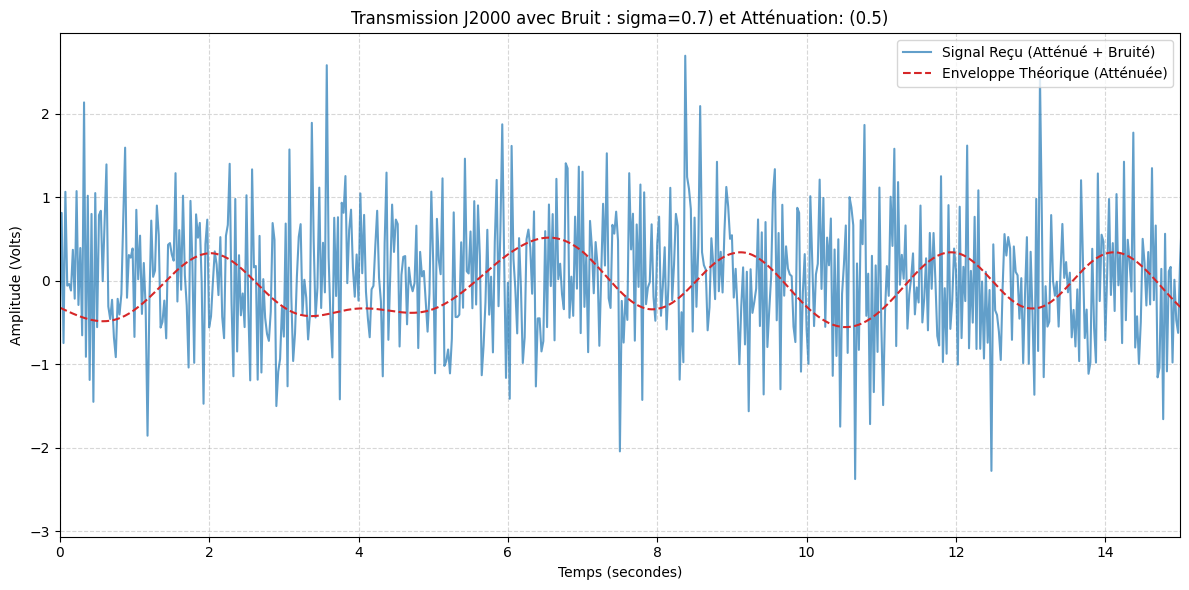

In [231]:
# signal de base 
# On utilise T=1s, fc=20Hz
data = generate_j2000_signal(test_coordinates, T=1.0, fc=20)

# Simulation du canal et ajout de bruit aléatoire
attenuation = 0.5
sigma_bruit = 0.7  # Intensité 


signal_recu = (data["modulated"] * attenuation) + np.random.normal(0, sigma_bruit, len(data["modulated"]))


enveloppe_theorique_attenuee = data["baseband"] * attenuation
plt.figure(figsize=(12, 6))

# signal bruité reçu
plt.plot(data["t"], signal_recu, 
         label="Signal Reçu (Atténué + Bruité)", 
         color='tab:blue', 
         alpha=0.7)

# enveloppe théorique
plt.plot(data["t"], enveloppe_theorique_attenuee, 
         '--', 
         label="Enveloppe Théorique (Atténuée)", 
         color='tab:red', 
         linewidth=1.5)

# config du graphe
plt.title(f"Transmission J2000 avec Bruit : sigma={sigma_bruit}) et Atténuation: ({attenuation})")
plt.xlabel("Temps (secondes)")
plt.ylabel("Amplitude (Volts)")
plt.grid(True, linestyle='--', alpha=0.5)

# Zoom 
plt.xlim(0, 15) 
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()


Simulate the **receiver front-end**: after the noisy RF waveform arrives we (crudely) <span style="color:#BF40BF;">**multiply it by the carrier frequency**</span> to bring the spectrum back to **base-band**.



<span style="color:#3498db;">**Sample at the symbol epochs**</span> to decide **0 vs 1**, then re-assemble the **384-bit sequence** into **six doubles**.

Finally, print the <span style="color:#2ecc71;">**recovered J2000 coordinates**</span> so we can judge whether the **link budget** (<span style="color:#e67e22;">**attenuation + WSS noise**</span>) still allows **perfect decoding**.

In [232]:
def decode_signal_to_j2000_final(signal_recu, t_signal, fc, T, dt, span):
    # DEMODULATION
    demod = signal_recu * np.cos(2 * np.pi * fc * t_signal)
    
    # le bit envoyé à t = 0 --> décalé au centre 
    bits_recuperes = []
    
    for i in range(384):
        #rajout d'un délai pour le centre 
        t_ideal = i * T
        
        # On cherche l'index
        idx = int(round(t_ideal / dt))
        
        if idx < len(demod):
            bits_recuperes.append(1 if demod[idx] > 0 else 0)

    # Bits -> Octets -> Doubles
    coords_decodees = []
    if len(bits_recuperes) >= 384:
        vecteur_bits = bits_recuperes[:384]
        composantes = []
        for c in range(0, 384, 64):
            un_nombre_bits = vecteur_bits[c:c+64]
            octets = bytearray()
            for b in range(0, 64, 8):
                byte_bits = un_nombre_bits[b:b+8]
                
                byte_val = 0
                for bit in byte_bits:
                    byte_val = (byte_val << 1) | bit
                octets.append(byte_val)
            
            # Reconstruction 
            composantes.append(struct.unpack('<d', octets)[0])
        coords_decodees.append(composantes)
        
    return coords_decodees

# --- TEST ---

coords_finales = decode_signal_to_j2000_final(signal_recu, data["t"], fc=20, T=1.0, dt=data["dt"], span=6)

if coords_finales:
    print("--- RÉSULTATS ---")
    print(f"Coordonnées originales : {test_coordinates[0]}")
    print(f"Coordonnées décodées   : {coords_finales[0]}")
else:
    print("Échec du décodage : Aucune coordonnée trouvée.")


--- RÉSULTATS ---
Coordonnées originales : [-0.1742, 0.9689, 0.0001458, -29.78, -5.21, 0.001]
Coordonnées décodées   : [3.161850518745752e-248, -1.4700806679163587e-08, -0.038785815517840445, 1.6298244573850368e-291, -23446455899.635464, 3.461379121180688e-195]


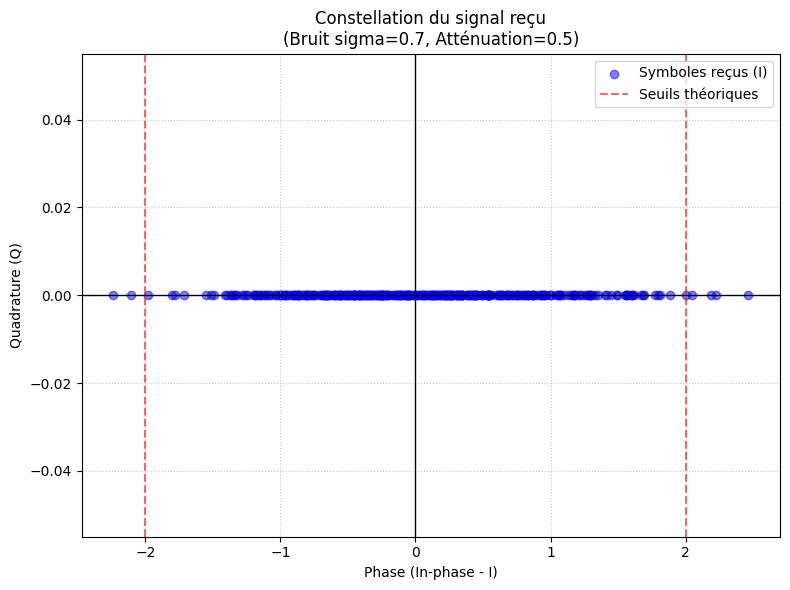

In [233]:
# --- TRACÉCONSTELLATION ---


# échantillons à t = i * T

symboles_recuperes = []
for i in range(384):
    t_ideal = i * T
    idx = int(round(t_ideal / data["dt"]))
    if idx < len(signal_recu):
        # On extrait la composante I
        val = signal_recu[idx] * np.cos(2 * np.pi * fc * t_ideal)
        symboles_recuperes.append(val)


plt.figure(figsize=(8, 6))
# En BPSK Q est nul
plt.scatter(symboles_recuperes, np.zeros_like(symboles_recuperes), 
            alpha=0.5, color='blue', label='Symboles reçus (I)')

# plot settings 

plt.axvline(x=4 * attenuation, color='red', linestyle='--', alpha=0.6, label='Seuils théoriques')
plt.axvline(x=-4 * attenuation, color='red', linestyle='--', alpha=0.6)

plt.title(f"Constellation du signal reçu\n(Bruit sigma={sigma_bruit}, Atténuation={attenuation})")
plt.xlabel("Phase (In-phase - I)")
plt.ylabel("Quadrature (Q)")
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


### 1. Bit Mapping (Grouping by 2)

In BPSK, 1 bit = 1 symbol. In <span style="color:#3498db;">**QPSK**</span>, **2 bits = 1 symbol**.

* **Action:** You must split your 384-bit stream into pairs.
* **Component Calculation:** Each pair $(b_1, b_2)$ defines a point in the complex plane:
    * The <span style="color:#e67e22;">**I component (In-phase)**</span> is driven by the first bit.
    * The <span style="color:#2ecc71;">**Q component (Quadrature)**</span> is driven by the second bit.

### 2. Pulse Shaping (Raised Cosine Filtering)

The filter remains the same, but you must apply it twice.

* **Action:** Generate one impulse train for **I** and another for **Q**.
* **Filtering:** Convolve each impulse train with the same <span style="color:#1F51FF;">**Raised Cosine**</span> impulse response ($h_{rc}$). This yields two baseband signals: $I(t)$ and $Q(t)$.

### 3. IQ Modulation

This is the stage where both signals merge onto the same carrier frequency but with a phase shift.

$$s(t) = I(t) \cdot \cos(2\pi f_c t) - Q(t) \cdot \sin(2\pi f_c t)$$

> <span style="color:#BF40BF;">**Note:**</span> The "minus" sign is the standard convention to remain consistent with complex representations.

### 4. Demodulation (Recovery)

Upon reception, to recover the bits, the received signal must be projected onto both axes.

* **To extract I:** Multiply the received signal by $\cos(2\pi f_c t)$ and filter (or sample at optimal instances).
* **To extract Q:** Multiply the received signal by $-\sin(2\pi f_c t)$ and filter.

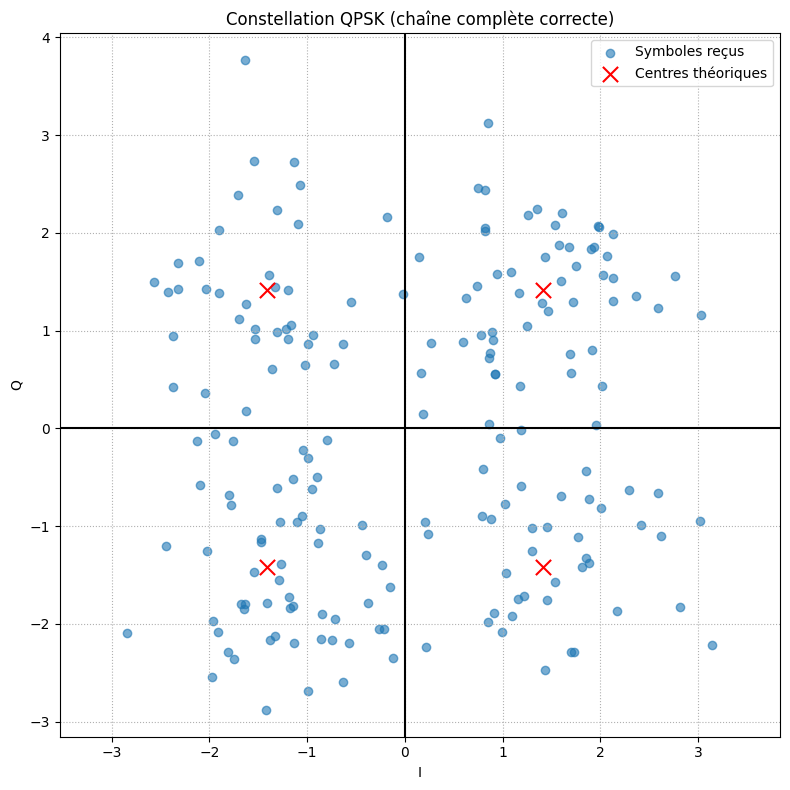

In [234]:
# QPSK

bits = j2000_to_bit_list(test_coordinates)

# nb de bits pair
if len(bits) % 2 != 0:
    bits.append(0)

# MAPPING NE PAS MODIFIER
A = 4 / np.sqrt(2)
symbols_I = []
symbols_Q = []

for i in range(0, len(bits), 2):
    b1, b2 = bits[i], bits[i+1]
    symbols_I.append(A if b1 == 1 else -A)
    symbols_Q.append(A if b2 == 1 else -A)

# Padding pour le filtre
symbols_I += [0] * span
symbols_Q += [0] * span

# Paramètres temporels 
samples_per_symbol = 40
dt = T / samples_per_symbol

# impulses
impulses_I = np.zeros(len(symbols_I) * samples_per_symbol)
impulses_Q = np.zeros(len(symbols_Q) * samples_per_symbol)

for k in range(len(symbols_I)):
    impulses_I[k * samples_per_symbol] = symbols_I[k]
    impulses_Q[k * samples_per_symbol] = symbols_Q[k]

# filtrage signal RC
t_rc, h_rc = raised_cosine(T, beta, span, dt)
h_rc = h_rc / np.sqrt(np.sum(h_rc**2))

baseband_I = np.convolve(impulses_I, h_rc, mode='same')
baseband_Q = np.convolve(impulses_Q, h_rc, mode='same')

# Modulation sur I et sur Q 
t_signal = np.arange(len(baseband_I)) * dt
fc = 10 / T

signal_emis = baseband_I * np.cos(2 * np.pi * fc * t_signal) - \
              baseband_Q * np.sin(2 * np.pi * fc * t_signal)

# canal
attenuation_qpsk = 0.5
sigma_bruit_qpsk = 0.5

signal_recu = attenuation_qpsk * signal_emis + np.random.normal(0, sigma_bruit_qpsk, len(signal_emis))

# démodulation
i_raw = signal_recu * np.cos(2 * np.pi * fc * t_signal) * 2
q_raw = -signal_recu * np.sin(2 * np.pi * fc * t_signal) * 2

# filtrage
i_filt = np.convolve(i_raw, h_rc, mode='same')
q_filt = np.convolve(q_raw, h_rc, mode='same')

# et l'échantillonage
delay = int((span * T / 2) / dt)
samples_per_symbol = int(T / dt)

symb_I = []
symb_Q = []

num_symbols = len(bits) // 2

for k in range(num_symbols):
    idx = delay + k * samples_per_symbol
    if idx < len(i_filt):
        symb_I.append(i_filt[idx])
        symb_Q.append(q_filt[idx])

symb_I = np.array(symb_I)
symb_Q = np.array(symb_Q)

# le plot
plt.figure(figsize=(8,8))
plt.scatter(symb_I, symb_Q, alpha=0.6, label="Symboles reçus")

A_att = A * attenuation_qpsk
theo = np.array([[ A_att,  A_att],
                 [-A_att,  A_att],
                 [-A_att, -A_att],
                 [ A_att, -A_att]])

plt.scatter(theo[:,0], theo[:,1], c='red', s=120, marker='x', label="Centres théoriques")

plt.axhline(0,color='black')
plt.axvline(0,color='black')
plt.grid(True, linestyle=':')
plt.axis('equal')
plt.title("Constellation QPSK (chaîne complète correcte)")
plt.xlabel("I")
plt.ylabel("Q")
plt.legend()
plt.tight_layout()
plt.show()



We notice that the points are <span style="color:#e74c3c;">**highly spaced out**</span> from the theoretical centers; this is likely due to an error in the choice of **gain A**.

**FROM:**

```python
i_raw = signal_recu * np.cos(2 * np.pi * fc * t_signal) * 2
q_raw = -signal_recu * np.sin(2 * np.pi * fc * t_signal) * 2

```
**TO**
```python
i_raw = signal_recu * np.cos(2 * np.pi * fc * t_signal)
q_raw = -signal_recu * np.sin(2 * np.pi * fc * t_signal)

```



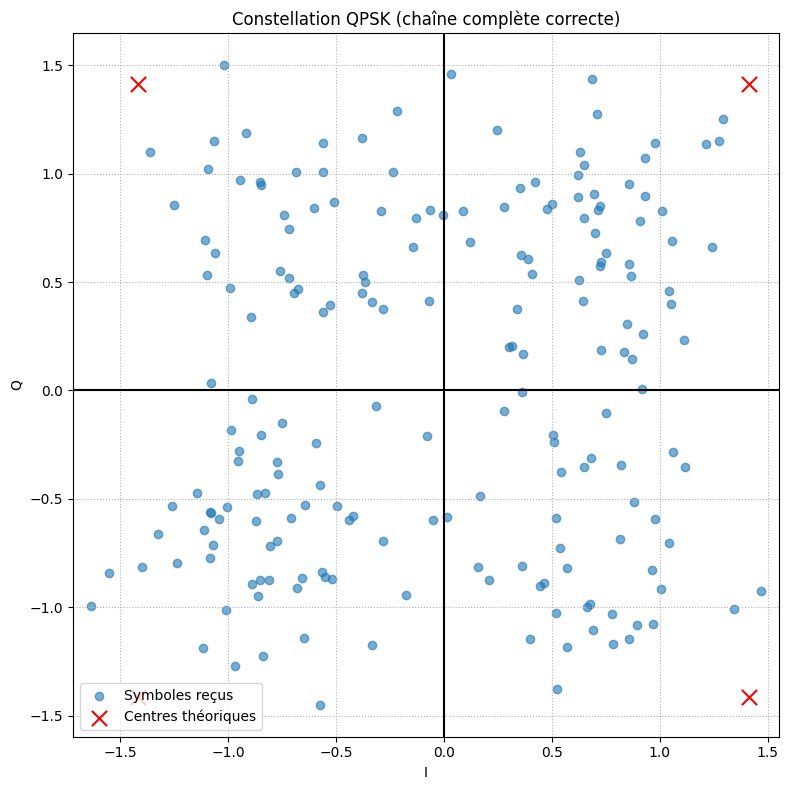

In [235]:
# QPSK

bits = j2000_to_bit_list(test_coordinates)

# nb de bits pair
if len(bits) % 2 != 0:
    bits.append(0)

# MAPPING NE PAS MODIFIER
A = 4 / np.sqrt(2)
symbols_I = []
symbols_Q = []

for i in range(0, len(bits), 2):
    b1, b2 = bits[i], bits[i+1]
    symbols_I.append(A if b1 == 1 else -A)
    symbols_Q.append(A if b2 == 1 else -A)

# Padding pour le filtre
symbols_I += [0] * span
symbols_Q += [0] * span

# Paramètres temporels 
samples_per_symbol = 40
dt = T / samples_per_symbol

# impulses
impulses_I = np.zeros(len(symbols_I) * samples_per_symbol)
impulses_Q = np.zeros(len(symbols_Q) * samples_per_symbol)

for k in range(len(symbols_I)):
    impulses_I[k * samples_per_symbol] = symbols_I[k]
    impulses_Q[k * samples_per_symbol] = symbols_Q[k]

# filtrage signal RC
t_rc, h_rc = raised_cosine(T, beta, span, dt)
h_rc = h_rc / np.sqrt(np.sum(h_rc**2))

baseband_I = np.convolve(impulses_I, h_rc, mode='same')
baseband_Q = np.convolve(impulses_Q, h_rc, mode='same')

# Modulation sur I et sur Q 
t_signal = np.arange(len(baseband_I)) * dt
fc = 10 / T

signal_emis = baseband_I * np.cos(2 * np.pi * fc * t_signal) - \
              baseband_Q * np.sin(2 * np.pi * fc * t_signal)

# canal
attenuation_qpsk = 0.5
sigma_bruit_qpsk = 0.5

signal_recu = attenuation_qpsk * signal_emis + np.random.normal(0, sigma_bruit_qpsk, len(signal_emis))

# démodulation
i_raw = signal_recu * np.cos(2 * np.pi * fc * t_signal)   #################################
q_raw = -signal_recu * np.sin(2 * np.pi * fc * t_signal)  #################################

# filtrage
i_filt = np.convolve(i_raw, h_rc, mode='same')
q_filt = np.convolve(q_raw, h_rc, mode='same')

# et l'échantillonage
delay = int((span * T / 2) / dt)
samples_per_symbol = int(T / dt)

symb_I = []
symb_Q = []

num_symbols = len(bits) // 2

for k in range(num_symbols):
    idx = delay + k * samples_per_symbol
    if idx < len(i_filt):
        symb_I.append(i_filt[idx])
        symb_Q.append(q_filt[idx])

symb_I = np.array(symb_I)
symb_Q = np.array(symb_Q)

# le plot
plt.figure(figsize=(8,8))
plt.scatter(symb_I, symb_Q, alpha=0.6, label="Symboles reçus")

A_att = A * attenuation_qpsk
theo = np.array([[ A_att,  A_att],
                 [-A_att,  A_att],
                 [-A_att, -A_att],
                 [ A_att, -A_att]])

plt.scatter(theo[:,0], theo[:,1], c='red', s=120, marker='x', label="Centres théoriques")

plt.axhline(0,color='black')
plt.axvline(0,color='black')
plt.grid(True, linestyle=':')
plt.axis('equal')
plt.title("Constellation QPSK (chaîne complète correcte)")
plt.xlabel("I")
plt.ylabel("Q")
plt.legend()
plt.tight_layout()
plt.show()



We see that it doesnt change much, let's try changing fc.

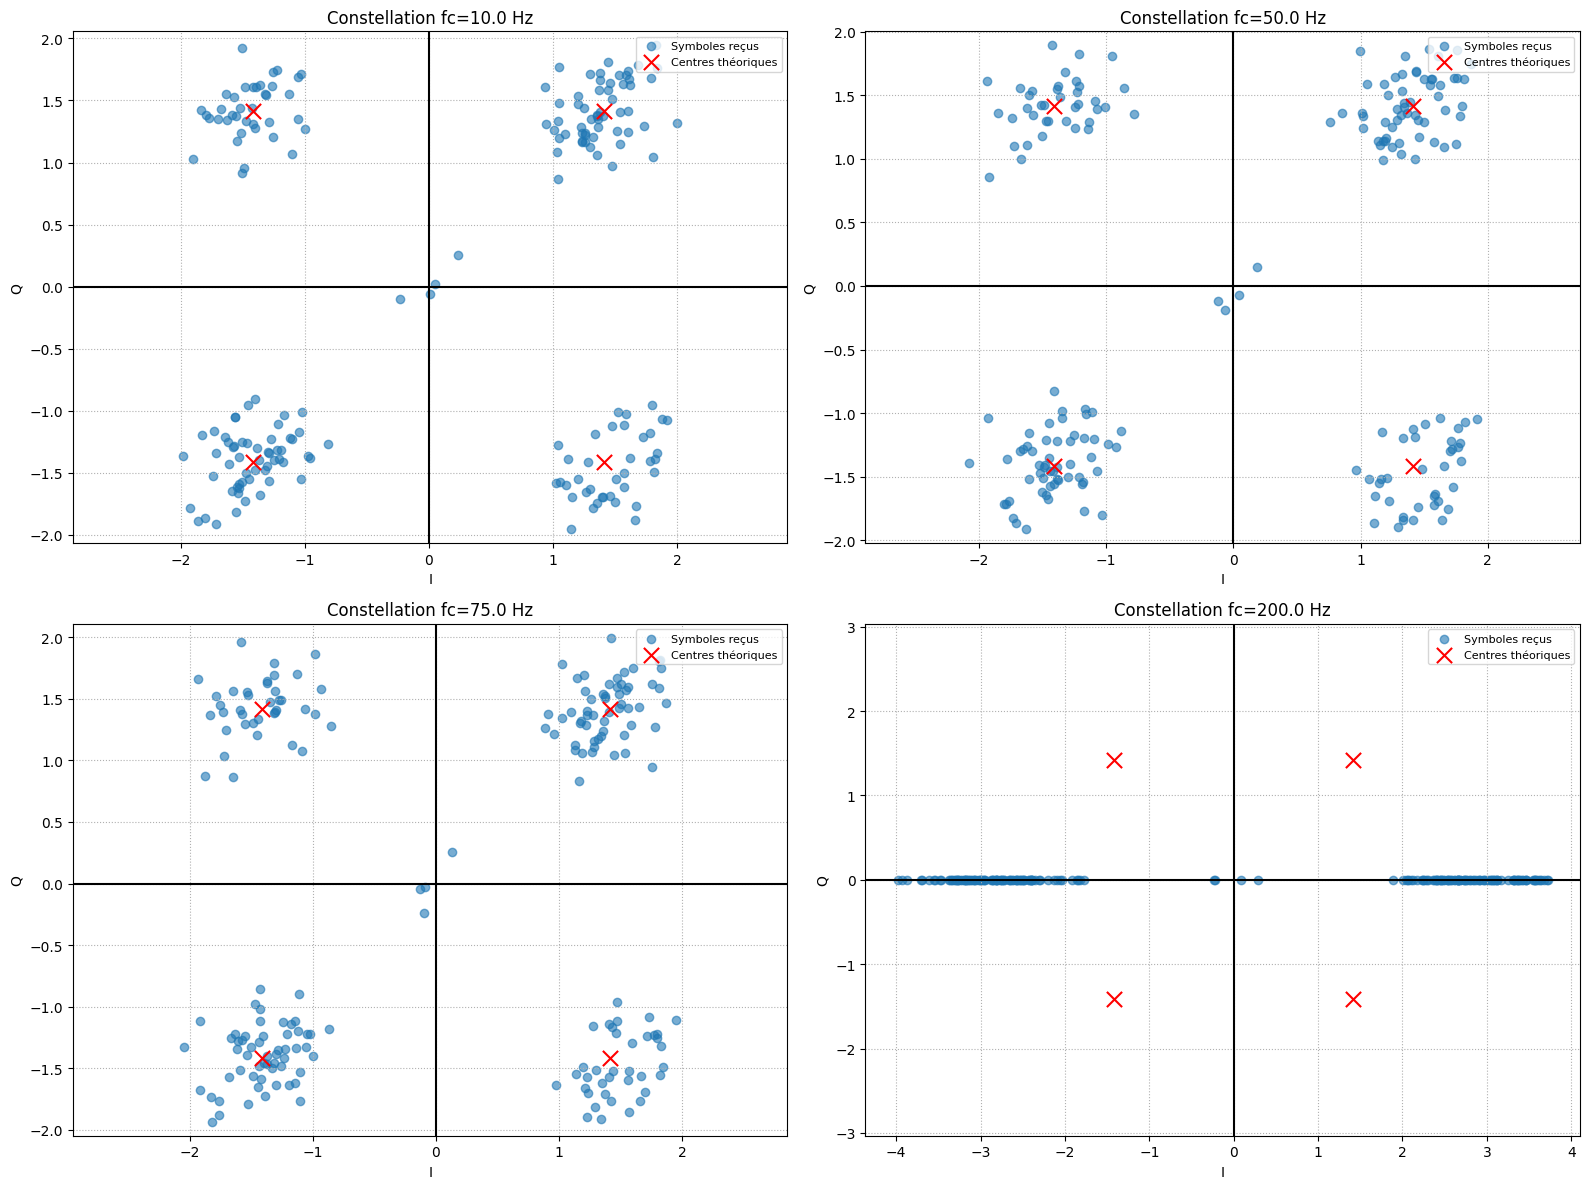

In [236]:
# tests pour des fc différents



fc_list = [10/T, 50/T, 75/T, 200/T]  # liste des frequences
attenuation_qpsk = 0.5
sigma_bruit_qpsk = 0.05  # remettre à 0 pour voir les centres

plt.figure(figsize=(16, 12))


#Reutiliser le meme code qu'en haut mais bouclé 

for i, fc_test in enumerate(fc_list):
    
    signal_emis = baseband_I * np.cos(2 * np.pi * fc_test * t_signal) - \
                  baseband_Q * np.sin(2 * np.pi * fc_test * t_signal)

    
    signal_recu_test = attenuation_qpsk * signal_emis + np.random.normal(0, sigma_bruit_qpsk, len(signal_emis))

   
    i_raw = signal_recu_test * np.cos(2 * np.pi * fc_test * t_signal) * 2
    q_raw = -signal_recu_test * np.sin(2 * np.pi * fc_test * t_signal) * 2

    i_filt = np.convolve(i_raw, h_rc, mode='same')
    q_filt = np.convolve(q_raw, h_rc, mode='same')

   
    delay = int((span * T / 2) / dt)
    samples_per_symbol = int(T / dt)
    symb_I = []
    symb_Q = []

    num_symbols = len(bits) // 2
    for k in range(num_symbols):
        idx = delay + k * samples_per_symbol
        if idx < len(i_filt):
            symb_I.append(i_filt[idx])
            symb_Q.append(q_filt[idx])

    symb_I = np.array(symb_I)
    symb_Q = np.array(symb_Q)

    # tracé avec des subplots
    plt.subplot(2, 2, i+1)
    plt.scatter(symb_I, symb_Q, alpha=0.6, label="Symboles reçus")
    A_att = A * attenuation_qpsk
    theo = np.array([[ A_att,  A_att],
                     [-A_att,  A_att],
                     [-A_att, -A_att],
                     [ A_att, -A_att]])
    plt.scatter(theo[:,0], theo[:,1], c='red', s=120, marker='x', label="Centres théoriques")
    plt.axhline(0,color='black')
    plt.axvline(0,color='black')
    plt.grid(True, linestyle=':')
    plt.axis('equal')
    plt.title(f"Constellation fc={fc_test:.1f} Hz")
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()




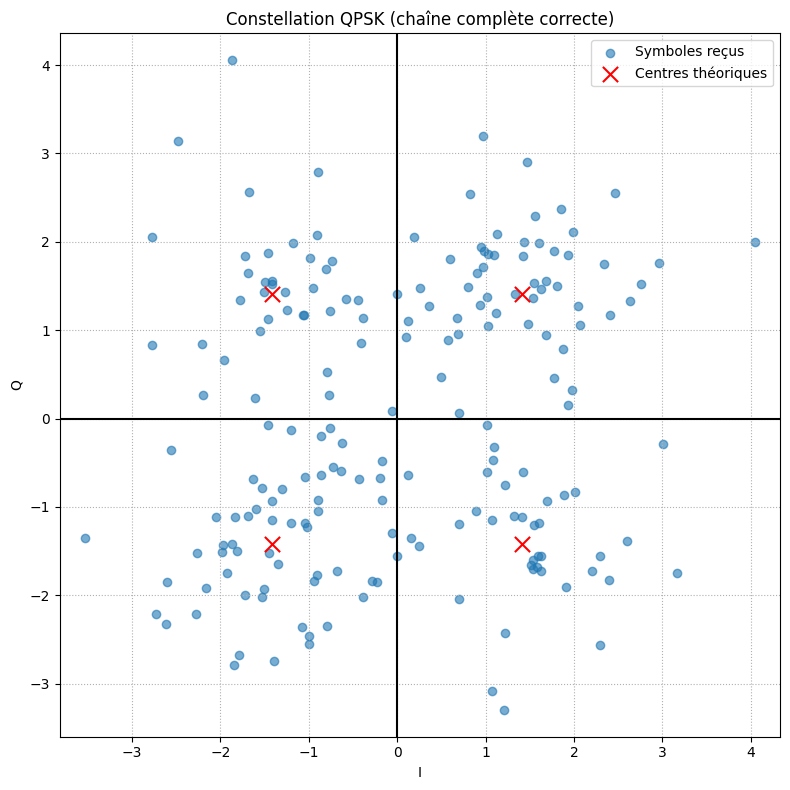

In [237]:
# =========================================
# CONSTRUCTION QPSK + DÉMODULATION PROPRE
# =========================================

# --- 1) Conversion en bits ---
bits = j2000_to_bit_list(test_coordinates)

# S'assurer d'un nombre pair de bits
if len(bits) % 2 != 0:
    bits.append(0)

# --- 2) Mapping QPSK ---
A = 4 / np.sqrt(2)
symbols_I = []
symbols_Q = []

for i in range(0, len(bits), 2):
    b1, b2 = bits[i], bits[i+1]
    symbols_I.append(A if b1 == 1 else -A)
    symbols_Q.append(A if b2 == 1 else -A)

# Padding pour le filtre
symbols_I += [0] * span
symbols_Q += [0] * span

# --- 3) Paramètres temporels ---
samples_per_symbol = 40
dt = T / samples_per_symbol

# --- 4) Trains d'impulsions ---
impulses_I = np.zeros(len(symbols_I) * samples_per_symbol)
impulses_Q = np.zeros(len(symbols_Q) * samples_per_symbol)

for k in range(len(symbols_I)):
    impulses_I[k * samples_per_symbol] = symbols_I[k]
    impulses_Q[k * samples_per_symbol] = symbols_Q[k]

# --- 5) Filtrage Raised Cosine ---
t_rc, h_rc = raised_cosine(T, beta, span, dt)
h_rc = h_rc / np.sqrt(np.sum(h_rc**2))

baseband_I = np.convolve(impulses_I, h_rc, mode='same')
baseband_Q = np.convolve(impulses_Q, h_rc, mode='same')

# --- 6) Modulation IQ ---
t_signal = np.arange(len(baseband_I)) * dt
fc = 10 / T

signal_emis = baseband_I * np.cos(2 * np.pi * fc * t_signal) - \
              baseband_Q * np.sin(2 * np.pi * fc * t_signal)

# --- 7) Canal ---
attenuation_qpsk = 0.5
sigma_bruit_qpsk = 0.5

signal_recu = attenuation_qpsk * signal_emis + np.random.normal(0, sigma_bruit_qpsk, len(signal_emis))

# --- 8) Démodulation IQ ---
i_raw = signal_recu * np.cos(2 * np.pi * fc * t_signal) * 2
q_raw = -signal_recu * np.sin(2 * np.pi * fc * t_signal) * 2

# --- 9) Filtre adapté ---
i_filt = np.convolve(i_raw, h_rc, mode='same')
q_filt = np.convolve(q_raw, h_rc, mode='same')

# --- 10) Échantillonnage synchronisé ---
delay = int((span * T / 2) / dt)
samples_per_symbol = int(T / dt)

symb_I = []
symb_Q = []

num_symbols = len(bits) // 2

for k in range(num_symbols):
    idx = delay + k * samples_per_symbol
    if idx < len(i_filt):
        symb_I.append(i_filt[idx])
        symb_Q.append(q_filt[idx])

symb_I = np.array(symb_I)
symb_Q = np.array(symb_Q)

# --- 11) Tracé constellation ---
plt.figure(figsize=(8,8))
plt.scatter(symb_I, symb_Q, alpha=0.6, label="Symboles reçus")

A_att = A * attenuation_qpsk
theo = np.array([[ A_att,  A_att],
                 [-A_att,  A_att],
                 [-A_att, -A_att],
                 [ A_att, -A_att]])

plt.scatter(theo[:,0], theo[:,1], c='red', s=120, marker='x', label="Centres théoriques")

plt.axhline(0,color='black')
plt.axvline(0,color='black')
plt.grid(True, linestyle=':')
plt.axis('equal')
plt.title("Constellation QPSK (chaîne complète correcte)")
plt.xlabel("I")
plt.ylabel("Q")
plt.legend()
plt.tight_layout()
plt.show()



 On remarque que les points sont hyper espacés des centres théoriques, cela est surement du à une erreur de choix du gain A.



 Changements :

 ON PASSE DE

 i_raw = signal_recu * np.cos(2 * np.pi * fc * t_signal) * 2

 q_raw = -signal_recu * np.sin(2 * np.pi * fc * t_signal) * 2



 A

 i_raw = signal_recu * np.cos(2 * np.pi * fc * t_signal)

 q_raw = -signal_recu * np.sin(2 * np.pi * fc * t_signal)





In [238]:
# %%

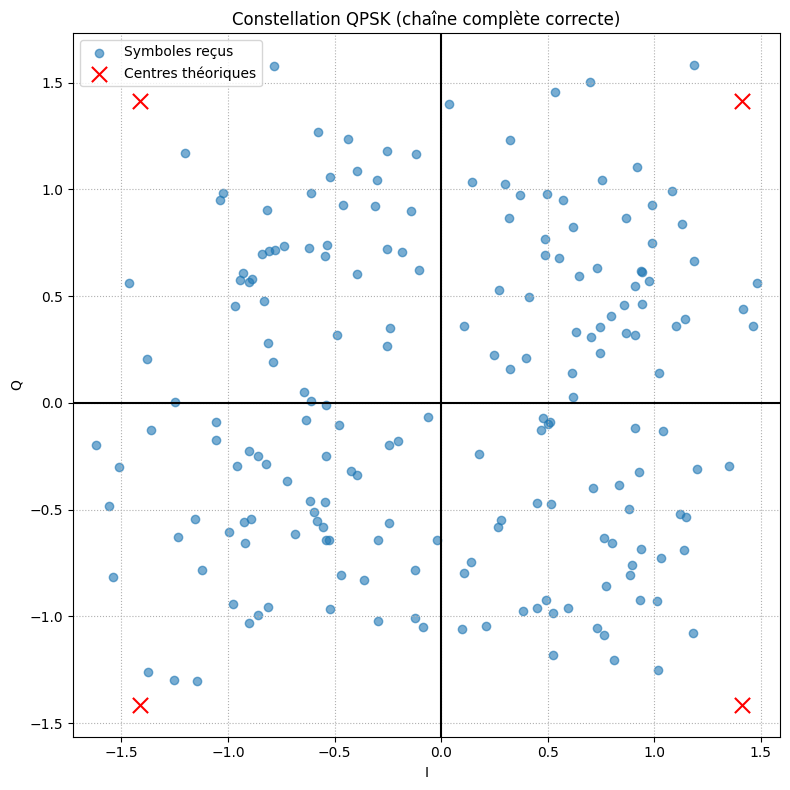

In [239]:
# =========================================
# CONSTRUCTION QPSK + DÉMODULATION PROPRE
# =========================================

# --- 1) Conversion en bits ---
bits = j2000_to_bit_list(test_coordinates)

# S'assurer d'un nombre pair de bits
if len(bits) % 2 != 0:
    bits.append(0)

# --- 2) Mapping QPSK ---
A = 4 / np.sqrt(2)
symbols_I = []
symbols_Q = []

for i in range(0, len(bits), 2):
    b1, b2 = bits[i], bits[i+1]
    symbols_I.append(A if b1 == 1 else -A)
    symbols_Q.append(A if b2 == 1 else -A)

# Padding pour le filtre
symbols_I += [0] * span
symbols_Q += [0] * span

# --- 3) Paramètres temporels ---
samples_per_symbol = 40
dt = T / samples_per_symbol

# --- 4) Trains d'impulsions ---
impulses_I = np.zeros(len(symbols_I) * samples_per_symbol)
impulses_Q = np.zeros(len(symbols_Q) * samples_per_symbol)

for k in range(len(symbols_I)):
    impulses_I[k * samples_per_symbol] = symbols_I[k]
    impulses_Q[k * samples_per_symbol] = symbols_Q[k]

# --- 5) Filtrage Raised Cosine ---
t_rc, h_rc = raised_cosine(T, beta, span, dt)
h_rc = h_rc / np.sqrt(np.sum(h_rc**2))

baseband_I = np.convolve(impulses_I, h_rc, mode='same')
baseband_Q = np.convolve(impulses_Q, h_rc, mode='same')

# --- 6) Modulation IQ ---
t_signal = np.arange(len(baseband_I)) * dt
fc = 10 / T

signal_emis = baseband_I * np.cos(2 * np.pi * fc * t_signal) - \
              baseband_Q * np.sin(2 * np.pi * fc * t_signal)

# --- 7) Canal ---
attenuation_qpsk = 0.5
sigma_bruit_qpsk = 0.5

signal_recu = attenuation_qpsk * signal_emis + np.random.normal(0, sigma_bruit_qpsk, len(signal_emis))

# --- 8) Démodulation IQ ---
i_raw = signal_recu * np.cos(2 * np.pi * fc * t_signal)
q_raw = -signal_recu * np.sin(2 * np.pi * fc * t_signal)

# --- 9) Filtre adapté ---
i_filt = np.convolve(i_raw, h_rc, mode='same')
q_filt = np.convolve(q_raw, h_rc, mode='same')

# --- 10) Échantillonnage synchronisé ---
delay = int((span * T / 2) / dt)
samples_per_symbol = int(T / dt)

symb_I = []
symb_Q = []

num_symbols = len(bits) // 2

for k in range(num_symbols):
    idx = delay + k * samples_per_symbol
    if idx < len(i_filt):
        symb_I.append(i_filt[idx])
        symb_Q.append(q_filt[idx])

symb_I = np.array(symb_I)
symb_Q = np.array(symb_Q)

# --- 11) Tracé constellation ---
plt.figure(figsize=(8,8))
plt.scatter(symb_I, symb_Q, alpha=0.6, label="Symboles reçus")

A_att = A * attenuation_qpsk
theo = np.array([[ A_att,  A_att],
                 [-A_att,  A_att],
                 [-A_att, -A_att],
                 [ A_att, -A_att]])

plt.scatter(theo[:,0], theo[:,1], c='red', s=120, marker='x', label="Centres théoriques")

plt.axhline(0,color='black')
plt.axvline(0,color='black')
plt.grid(True, linestyle=':')
plt.axis('equal')
plt.title("Constellation QPSK (chaîne complète correcte)")
plt.xlabel("I")
plt.ylabel("Q")
plt.legend()
plt.tight_layout()
plt.show()



In [240]:
# %%

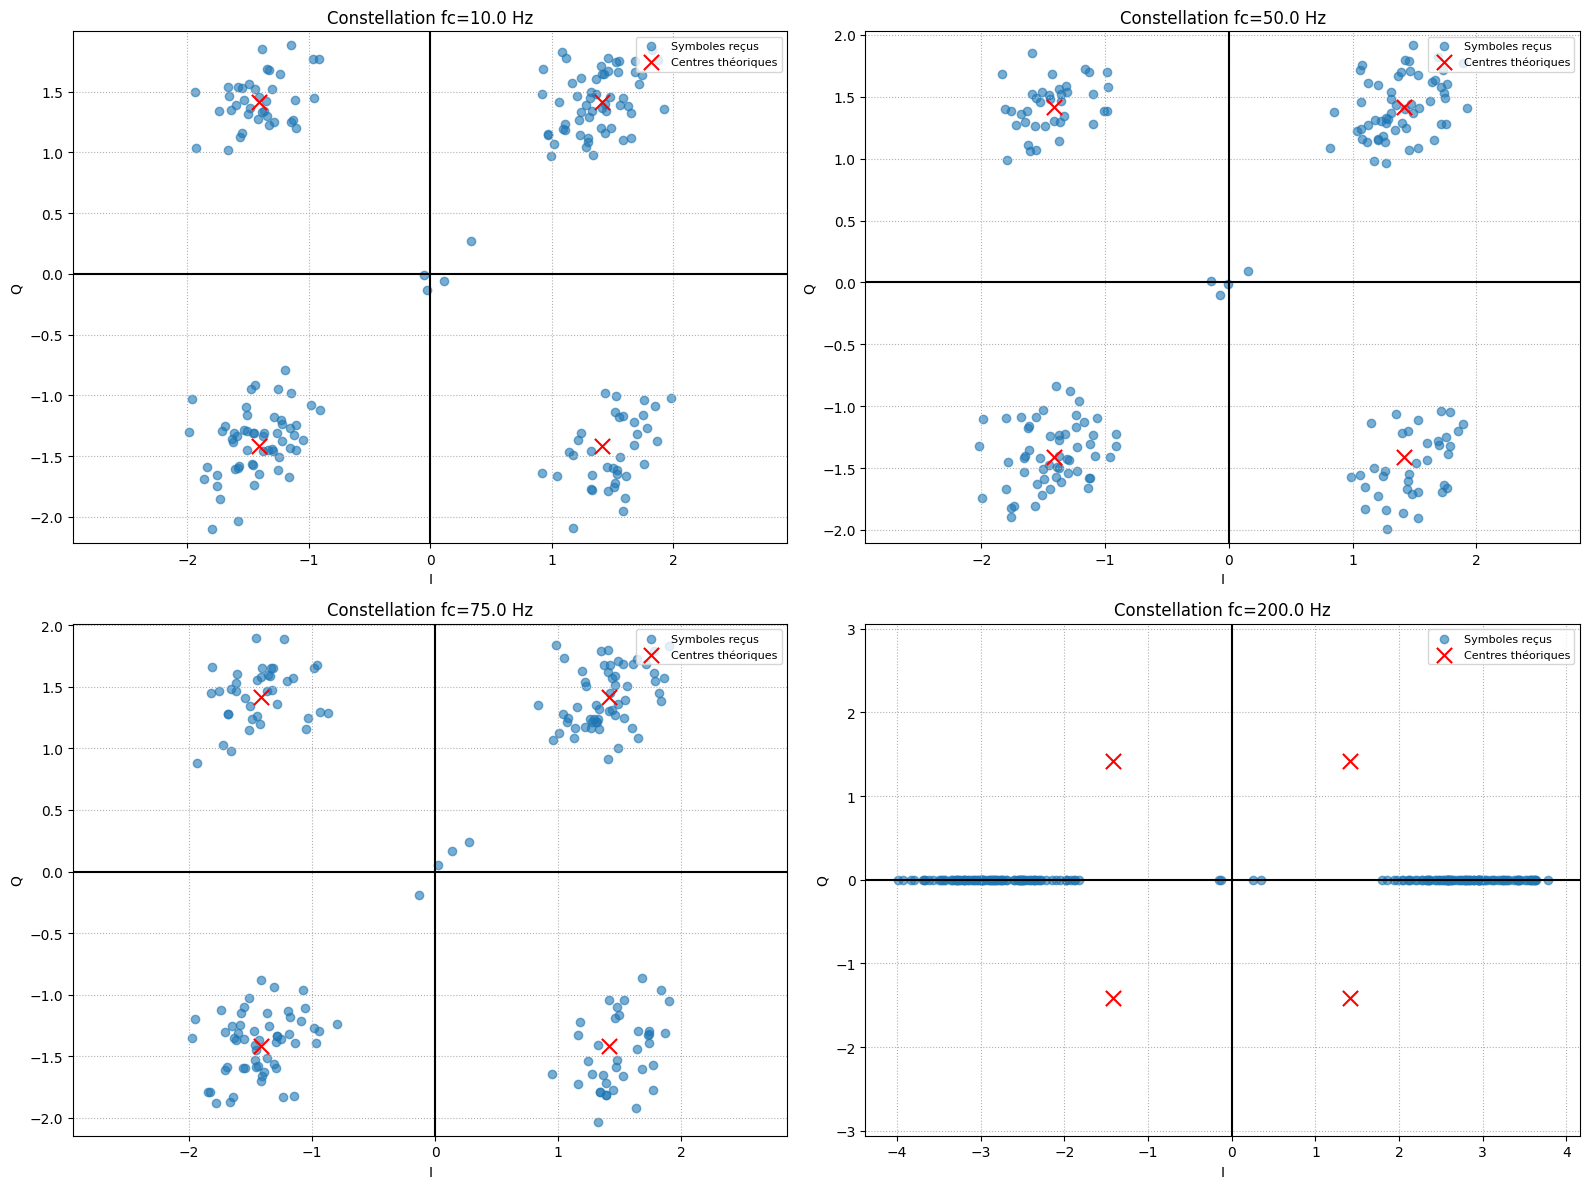

In [241]:
# =========================================
# TEST DE LA CONSTELLATION POUR DIFFÉRENTS fc
# =========================================

fc_list = [10/T, 50/T, 75/T, 200/T]  # Liste des porteuses à tester
attenuation_qpsk = 0.5
sigma_bruit_qpsk = 0.05  # Sans bruit pour bien voir les centres

plt.figure(figsize=(16, 12))

for i, fc_test in enumerate(fc_list):
    # --- Modulation IQ ---
    signal_emis = baseband_I * np.cos(2 * np.pi * fc_test * t_signal) - \
                  baseband_Q * np.sin(2 * np.pi * fc_test * t_signal)

    # --- Canal (juste atténuation) ---
    signal_recu_test = attenuation_qpsk * signal_emis + np.random.normal(0, sigma_bruit_qpsk, len(signal_emis))

    # --- Démodulation IQ ---
    i_raw = signal_recu_test * np.cos(2 * np.pi * fc_test * t_signal) * 2
    q_raw = -signal_recu_test * np.sin(2 * np.pi * fc_test * t_signal) * 2

    i_filt = np.convolve(i_raw, h_rc, mode='same')
    q_filt = np.convolve(q_raw, h_rc, mode='same')

    # --- Échantillonnage synchronisé ---
    delay = int((span * T / 2) / dt)
    samples_per_symbol = int(T / dt)
    symb_I = []
    symb_Q = []

    num_symbols = len(bits) // 2
    for k in range(num_symbols):
        idx = delay + k * samples_per_symbol
        if idx < len(i_filt):
            symb_I.append(i_filt[idx])
            symb_Q.append(q_filt[idx])

    symb_I = np.array(symb_I)
    symb_Q = np.array(symb_Q)

    # --- Tracé ---
    plt.subplot(2, 2, i+1)
    plt.scatter(symb_I, symb_Q, alpha=0.6, label="Symboles reçus")
    A_att = A * attenuation_qpsk
    theo = np.array([[ A_att,  A_att],
                     [-A_att,  A_att],
                     [-A_att, -A_att],
                     [ A_att, -A_att]])
    plt.scatter(theo[:,0], theo[:,1], c='red', s=120, marker='x', label="Centres théoriques")
    plt.axhline(0,color='black')
    plt.axvline(0,color='black')
    plt.grid(True, linestyle=':')
    plt.axis('equal')
    plt.title(f"Constellation fc={fc_test:.1f} Hz")
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()



In [242]:
# %%

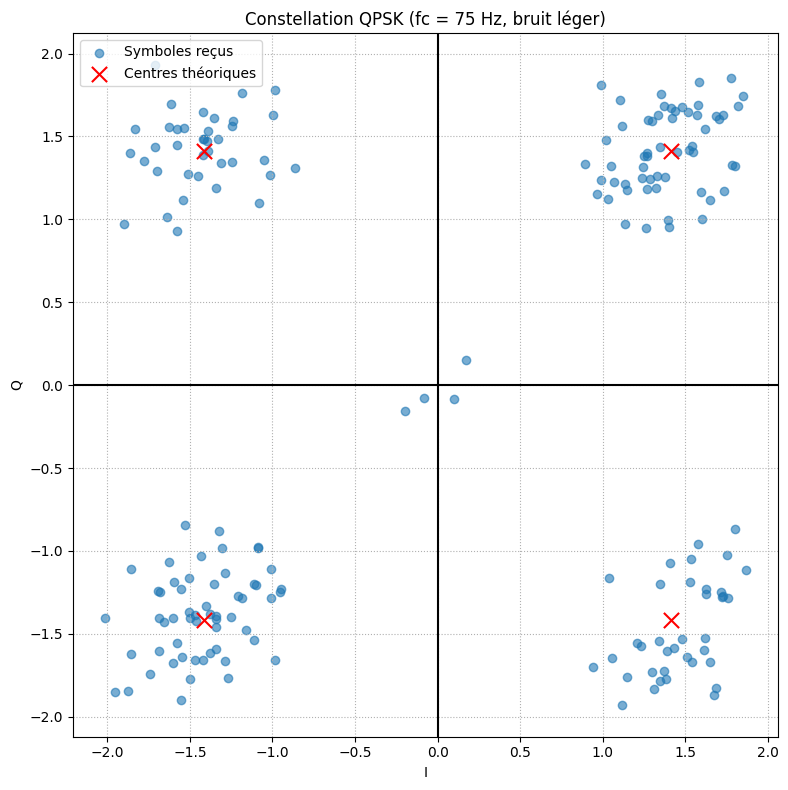

In [243]:
# =========================================
# CONSTRUCTION QPSK + DÉMODULATION PROPRE (fc = 75 Hz)
# =========================================

# --- 1) Conversion en bits ---
bits = j2000_to_bit_list(test_coordinates)

# S'assurer d'un nombre pair de bits
if len(bits) % 2 != 0:
    bits.append(0)

# --- 2) Mapping QPSK ---
A = 4 / np.sqrt(2)
symbols_I = []
symbols_Q = []

for i in range(0, len(bits), 2):
    b1, b2 = bits[i], bits[i+1]
    symbols_I.append(A if b1 == 1 else -A)
    symbols_Q.append(A if b2 == 1 else -A)

# Padding pour le filtre
symbols_I += [0] * span
symbols_Q += [0] * span

# --- 3) Paramètres temporels ---
samples_per_symbol = 40
dt = T / samples_per_symbol

# --- 4) Trains d'impulsions ---
impulses_I = np.zeros(len(symbols_I) * samples_per_symbol)
impulses_Q = np.zeros(len(symbols_Q) * samples_per_symbol)

for k in range(len(symbols_I)):
    impulses_I[k * samples_per_symbol] = symbols_I[k]
    impulses_Q[k * samples_per_symbol] = symbols_Q[k]

# --- 5) Filtrage Raised Cosine ---
t_rc, h_rc = raised_cosine(T, beta, span, dt)
h_rc = h_rc / np.sqrt(np.sum(h_rc**2))

baseband_I = np.convolve(impulses_I, h_rc, mode='same')
baseband_Q = np.convolve(impulses_Q, h_rc, mode='same')

# --- 6) Modulation IQ ---
t_signal = np.arange(len(baseband_I)) * dt
fc = 75  # Fréquence porteuse souhaitée

signal_emis = baseband_I * np.cos(2 * np.pi * fc * t_signal) - \
              baseband_Q * np.sin(2 * np.pi * fc * t_signal)

# --- 7) Canal (atténuation + bruit léger) ---
attenuation_qpsk = 0.5
sigma_bruit_qpsk = 0.05  # Bruit léger pour visualisation

signal_recu = attenuation_qpsk * signal_emis + np.random.normal(0, sigma_bruit_qpsk, len(signal_emis))

# --- 8) Démodulation IQ ---
i_raw = signal_recu * np.cos(2 * np.pi * fc * t_signal) * 2
q_raw = -signal_recu * np.sin(2 * np.pi * fc * t_signal) * 2

# --- 9) Filtre adapté ---
i_filt = np.convolve(i_raw, h_rc, mode='same')
q_filt = np.convolve(q_raw, h_rc, mode='same')

# --- 10) Échantillonnage synchronisé ---
delay = int((span * T / 2) / dt)
samples_per_symbol = int(T / dt)

symb_I = []
symb_Q = []

num_symbols = len(bits) // 2
for k in range(num_symbols):
    idx = delay + k * samples_per_symbol
    if idx < len(i_filt):
        symb_I.append(i_filt[idx])
        symb_Q.append(q_filt[idx])

symb_I = np.array(symb_I)
symb_Q = np.array(symb_Q)

# --- 11) Tracé constellation ---
plt.figure(figsize=(8,8))
plt.scatter(symb_I, symb_Q, alpha=0.6, label="Symboles reçus")

A_att = A * attenuation_qpsk
theo = np.array([[ A_att,  A_att],
                 [-A_att,  A_att],
                 [-A_att, -A_att],
                 [ A_att, -A_att]])
plt.scatter(theo[:,0], theo[:,1], c='red', s=120, marker='x', label="Centres théoriques")

plt.axhline(0,color='black')
plt.axvline(0,color='black')
plt.grid(True, linestyle=':')
plt.axis('equal')
plt.title("Constellation QPSK (fc = 75 Hz, bruit léger)")
plt.xlabel("I")
plt.ylabel("Q")
plt.legend()
plt.tight_layout()
plt.show()



 L'analyse énergétique de la transmission et de la réception des signaux BPSK (Binary Phase Shift Keying) et QPSK (Quadrature Phase Shift Keying) repose sur des concepts fondamentaux de la théorie des processus aléatoires, de la densité spectrale de puissance (DSP) et du rapport signal/bruit (SNR),.



 Voici une approche détaillée basée sur les sources pour réaliser cette analyse.



 ## 1. Analyse Énergétique à la Transmission



 Dans les communications numériques, le signal d'information discret $x[m]$ est transformé en un signal continu par une mise en forme d'impulsion (***pulse shaping***) et une modulation en quadrature pour former le signal de bande passante transmis $x_T(t)$,.



 ### Modélisation du Signal Transmis



 Le signal numérique est d'abord converti en une séquence de symboles $a[k]$ (appartenant à la constellation $C$). Pour les modulations numériques complexes comme la QPSK, on utilise une représentation en bande de base équivalente complexe $b_x(t)$, qui est la superposition des répliques décalées d'une impulsion $p(t)$ pondérée par le symbole $a[k]$ :



 $$b_x(t) = \sum_{k=-\infty}^{+\infty} a[k]p(t - k T_s)$$



 où $T_s$ est la durée du symbole (symbole *time*).



 Le signal transmis en bande passante $x_T(t)$ est ensuite lié à sa composante en bande de base $b_x(t)$ par une modulation de phase/quadrature,.



 ### Densité Spectrale de Puissance (DSP)



 L'analyse énergétique en transmission est effectuée en calculant la **DSP moyenne** $\bar{S}_{x_T}(f)$ du signal transmis $x_T(t)$,. La DSP moyenne est obtenue par la transformée de Fourier de la fonction d'autocorrélation (ACF) moyenne (Théorème de Wiener-Khintchine),,.



 En supposant que les symboles $a[k]$ sont incorrélés et de moyenne nulle (ce qui est souvent le cas pour les constellations numériques),, la DSP moyenne du signal transmis en bande passante est donnée par :



 $$\bar{S}_{x_T}(f) = \frac{1}{4} \bar{S}_{b_x}(f - f_c) + \frac{1}{4} \bar{S}_{b_x}(f + f_c)$$



 où $f_c$ est la fréquence porteuse et $\bar{S}_{b_x}(f)$ est la DSP moyenne du signal en bande de base $b_x(t)$ :



 $$\bar{S}_{b_x}(f) = \frac{\sigma_a^2}{T_s} |P(f)|^2$$



 où $\sigma_a^2 = E\{|a_i|^2\}$ est la **puissance de la constellation**,, et $P(f)$ est la transformée de Fourier de l'impulsion $p(t)$.



 ### Calcul de la Puissance et de l'Énergie



 La **puissance totale du signal transmis** ($S_T$) est obtenue en intégrant la DSP moyenne sur toutes les fréquences :



 $$S_T = \int_{-\infty}^{+\infty} \bar{S}_{x_T}(f) df$$



 En utilisant l'identité de Parseval et en notant que l'énergie $E_p$ de l'impulsion $p(t)$ est $E_p = \int_{-\infty}^{+\infty} |p(t)|^2 dt$, la puissance transmise est donnée par :



 $$S_T = \frac{1}{2} \frac{\sigma_a^2 E_p}{T_s}$$



 À partir de $S_T$, on définit les métriques énergétiques clés pour l'analyse :



 1.  **Énergie par Symbole** ($E_{s,c}$) : $E_{s,c} = S_T T_s = \frac{1}{2} \sigma_a^2 E_p$.

 2.  **Énergie par Bit** ($E_{b,c}$) : $E_{b,c} = \frac{E_{s,c}}{b}$, où $b = \log_2 M$ est le nombre de bits par symbole,.



 ### Application à BPSK et QPSK



 | Modulation | Nombre de symboles ($M$) | Bits par symbole ($b$) | Constellation ($C$) | Puissance de la Constellation ($\sigma_a^2$) | Relation $E_{s,c}$ et $E_{b,c}$ |

 | :---: | :---: | :---: | :---: | :---: | :---: |

 | **BPSK** | 2 | 1 | $C = \{-1, +1\}$ | $\sigma_a^2 = 1$ (si normalisé) | $E_{b,c} = E_{s,c}$ |

 | **QPSK** | 4 | 2 | $C = \{+1 \pm j, -1 \pm j\}$ (re-scale), | $\sigma_a^2$ à déterminer | $E_{b,c} = E_{s,c}/2$, |



 La puissance transmise $S_T$ se calcule ensuite en substituant la valeur de $\sigma_a^2$ et la forme du pulse $E_p$ dans la formule générale. Pour la QPSK, la puissance totale est également la somme des puissances des composantes en phase et en quadrature.



 ## 2. Analyse Énergétique à la Réception : SNR et Probabilité d'Erreur



 L'analyse énergétique à la réception se concentre sur la performance du système, généralement mesurée par le **Rapport Signal/Bruit (SNR)** et la **Probabilité d'Erreur Bit (BER)** ou **Symbole (SEP)**,,.



 ### Le Rapport Signal/Bruit (SNR)



 Le récepteur a pour tâche cruciale de minimiser la perte d'information introduite par le canal et le bruit,. Pour ce faire, un **filtre adapté** (*matched filter*) $h_D(t)$ est utilisé pour maximiser le SNR,.



 Le bruit $n(t)$ introduit par le canal est généralement modélisé comme un processus stochastique stationnaire au sens large (WSS) à moyenne nulle, caractérisé par une DSP plate $S_n(f) = N_0/2$ (bruit blanc). La puissance du bruit reçu dépend de la bande passante du filtre de réception,.



 En utilisant le filtre adapté, le **SNR maximum** atteint est directement lié à l'énergie du symbole $E_{s,c}$ et à la Densité Spectrale de Puissance du bruit $N_0$ :



 $$\text{SNR}_{MF, I} = \frac{2 E_{s,c}}{N_0}$$



 ### Probabilité d'Erreur (BPSK et QPSK)



 L'erreur de décision à la réception est analysée via le modèle du **canal équivalent discret**, où l'observation $z[m]$ du symbole transmis $a[m]$ est dégradée par un bruit gaussien $\eta[m]$,,.



 #### BPSK (Probabilité d'Erreur Bit/Symbole $P_\epsilon$)



 Pour la BPSK, la probabilité d'erreur de bit et de symbole coïncident puisque $b=1$. Le bruit $\eta_I[m]$ (bruit en phase) est une variable aléatoire gaussienne à moyenne nulle.



 La probabilité d'erreur $P_\epsilon$ est donnée par la fonction $Q(\cdot)$ appliquée au rapport de l'amplitude du signal sur l'écart-type du bruit ($\sigma_{\eta I}$). En remplaçant l'écart-type du bruit par sa relation avec l'énergie par bit $E_{b,c}$ :



 $$P_\epsilon = Q\left(\frac{1}{\sigma_{\eta I}}\right) = Q\left(\sqrt{\frac{2 E_{b,c}}{N_0}}\right)$$



 La fonction $Q(\cdot)$ étant monotone décroissante, plus le rapport $E_{b,c}/N_0$ est élevé, plus la probabilité d'erreur est faible,.



 #### QPSK (Probabilité d'Erreur Symbole $P_\epsilon$)



 La QPSK (b=2) utilise à la fois le canal en phase (I) et en quadrature (Q), chacun affecté par un bruit gaussien indépendant ($\eta_I[m]$ et $\eta_Q[m]$),.



 La Probabilité d'Erreur Symbole ($P_\epsilon$) est calculée en considérant que l'erreur se produit si la composante I ou la composante Q (ou les deux) est mal décidée,.



 En posant $\gamma = 1/\sigma_{\eta I} = 1/\sigma_{\eta Q}$ (en supposant des variances de bruit égales), la probabilité d'erreur de symbole est :



 $$P_\epsilon = 2Q(\gamma) - Q^2(\gamma)$$



 Pour les SNR élevés ($\gamma \gg 1$), cette probabilité est approximée par :



 $$P_\epsilon \approx 2Q(\gamma)$$



 La Probabilité d'Erreur Symbole pour la QPSK est approximativement le double de celle de la BPSK pour le même argument $\gamma$. Cependant, il faut noter que **l'information transmise est plus élevée** (2 bits par symbole au lieu de 1).



 **En résumé, l'analyse énergétique (et de performance) des signaux BPSK et QPSK est étroitement liée à la capacité à définir et optimiser l'énergie par bit ($E_{b,c}$), la puissance de la constellation ($\sigma_a^2$) et l'efficacité du filtre de réception pour maximiser le SNR par rapport à la densité de bruit $N_0$.**



In [244]:
# %%

--- Analyse Énergétique (BPSK) ---
Puissance totale du signal : 41.133 V²
Énergie par symbole        : 41.133 V²·s
Énergie par bit           : 41.133 V²·s


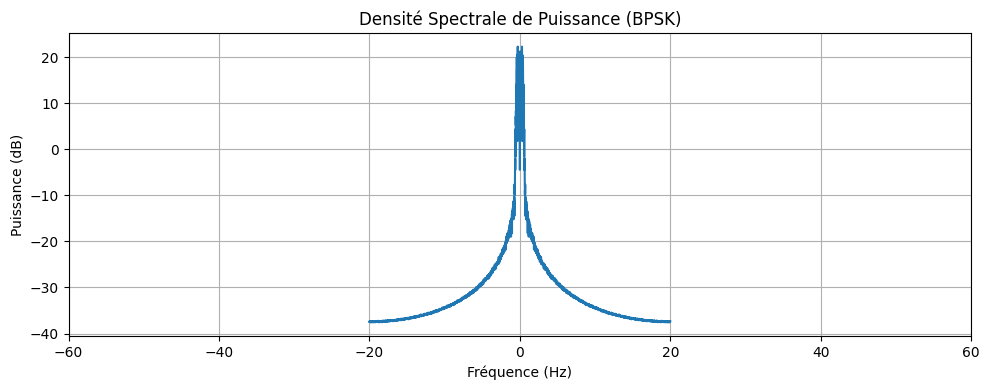

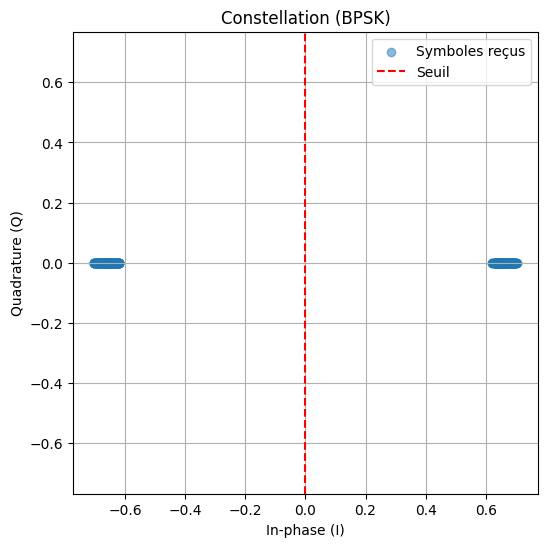

--- Analyse Énergétique (QPSK) ---
Puissance totale du signal : 20.443 V²
Énergie par symbole        : 20.443 V²·s
Énergie par bit           : 10.221 V²·s


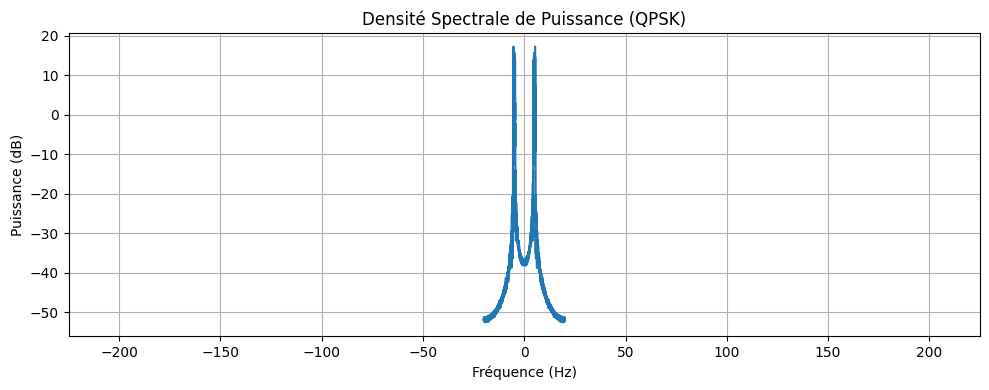

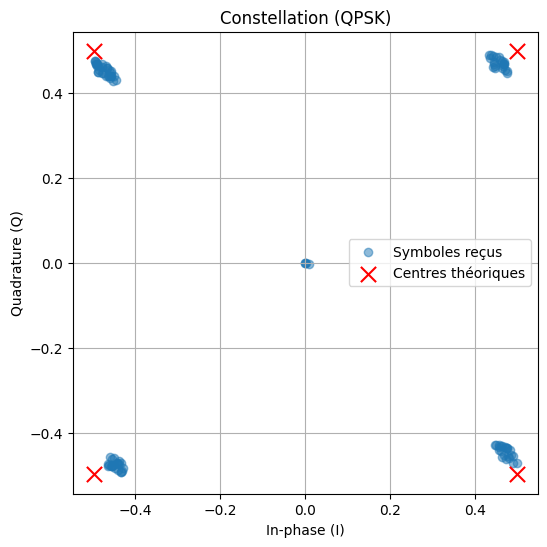

(np.float64(20.442976168381097),
 np.float64(20.442976168381097),
 np.float64(10.221488084190549))

In [245]:
# ==============================
# ANALYSE ÉNERGÉTIQUE BPSK & QPSK
# ==============================

import numpy as np
import matplotlib.pyplot as plt

def analyse_energetique(signal_baseband, bits_par_symbole=1, T=1.0, dt=0.01, fc=20):
    """
    Analyse énergétique d'un signal modulé BPSK ou QPSK.
    
    signal_baseband : signal en bande de base (1D numpy array)
    bits_par_symbole : 1 pour BPSK, 2 pour QPSK
    T : durée symbole (s)
    dt : pas d'échantillonnage
    fc : fréquence porteuse (Hz)
    """
    N = len(signal_baseband)
    
    # --- DSP ---
    NFFT = 4096
    S_f = np.fft.fftshift(np.fft.fft(signal_baseband, NFFT)) * dt
    freqs = np.fft.fftshift(np.fft.fftfreq(NFFT, dt))
    PSD = np.abs(S_f)**2
    
    # --- Puissance totale et énergie par symbole ---
    S_T = np.sum(PSD) * (freqs[1]-freqs[0])
    E_s = S_T * T
    E_b = E_s / bits_par_symbole
    
    print(f"--- Analyse Énergétique ({'BPSK' if bits_par_symbole==1 else 'QPSK'}) ---")
    print(f"Puissance totale du signal : {S_T:.3f} V²")
    print(f"Énergie par symbole        : {E_s:.3f} V²·s")
    print(f"Énergie par bit           : {E_b:.3f} V²·s")
    
    # --- Tracé DSP ---
    plt.figure(figsize=(10,4))
    plt.plot(freqs, 10*np.log10(PSD + 1e-12), label="PSD (dB)")
    plt.title(f"Densité Spectrale de Puissance ({'BPSK' if bits_par_symbole==1 else 'QPSK'})")
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Puissance (dB)")
    plt.xlim(-fc*3, fc*3)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # --- Constellation ---
    # Échantillonnage à T pour extraire symboles
    num_symb = N // int(T/dt)
    symb = [signal_baseband[int(k*T/dt)] for k in range(num_symb)]
    
    plt.figure(figsize=(6,6))
    if bits_par_symbole == 1:
        # BPSK : seulement axe I
        plt.scatter(symb, np.zeros_like(symb), alpha=0.5, label="Symboles reçus")
        plt.axvline(0, color='red', linestyle='--', label="Seuil")
        plt.xlabel("In-phase (I)")
        plt.ylabel("Quadrature (Q)")
    else:
        # QPSK : splitter I et Q
        symb_I = symb[::2]
        symb_Q = symb[1::2]
        plt.scatter(symb_I, symb_Q, alpha=0.5, label="Symboles reçus")
        A_est = max(np.abs(symb))
        theo = np.array([[ A_est,  A_est],
                         [-A_est,  A_est],
                         [-A_est, -A_est],
                         [ A_est, -A_est]])
        plt.scatter(theo[:,0], theo[:,1], c='red', marker='x', s=120, label='Centres théoriques')
        plt.xlabel("In-phase (I)")
        plt.ylabel("Quadrature (Q)")
    plt.title(f"Constellation ({'BPSK' if bits_par_symbole==1 else 'QPSK'})")
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.show()
    
    return S_T, E_s, E_b

# --- Analyse BPSK ---
# On prend ton signal BPSK de baseband (data["baseband"])
analyse_energetique(data["baseband"], bits_par_symbole=1, T=T, dt=data["dt"], fc=20)

# --- Analyse QPSK ---
# On prend le signal QPSK complet (signal_emis)
analyse_energetique(signal_emis, bits_par_symbole=2, T=T, dt=dt, fc=fc)




